In [1]:
import numpy as np
from MainFunctions import *
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from skimage import io, filters

In [2]:
#original 512 x 512
i_width = 256
i_height = 256
input_shape = i_width*i_height
print(input_shape)

65536


In [3]:
x_trn = []
x_tst = []

AddImageToArray(x_trn ,'DICOM\PA1\ST1\SE4', (i_width, i_height))
AddImageToArray(x_tst ,'DICOM\PA5\ST1\SE4', (i_width, i_height))

x_trn = np.array(x_trn, np.float32)
x_tst = np.array(x_tst, np.float32)

In [ ]:
y_trn = segmentation(x_trn, i_height, i_width, 6)
x_tst = segmentation(x_tst, i_height, i_width, 6)

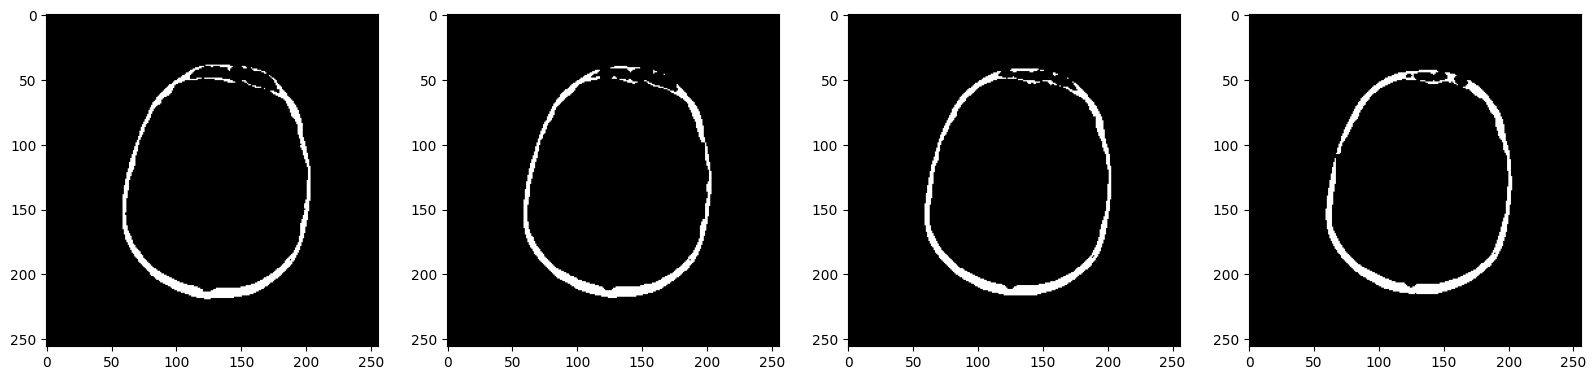

In [ ]:
plt.figure(figsize=(25,25))
color = 0
DrawImages(Add_noise(y_trn, color, i_height*0.3125, input_shape*0.1), 4, (5,5), 40)

In [ ]:
color = 0
x_trn = Add_noise(y_trn, color, i_height*0.3125, input_shape*0.1)

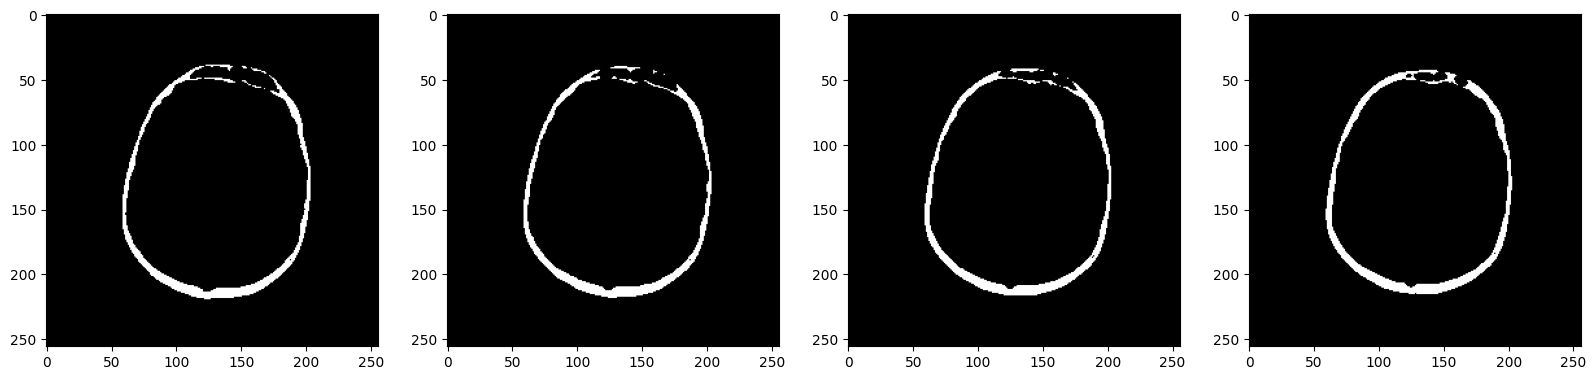

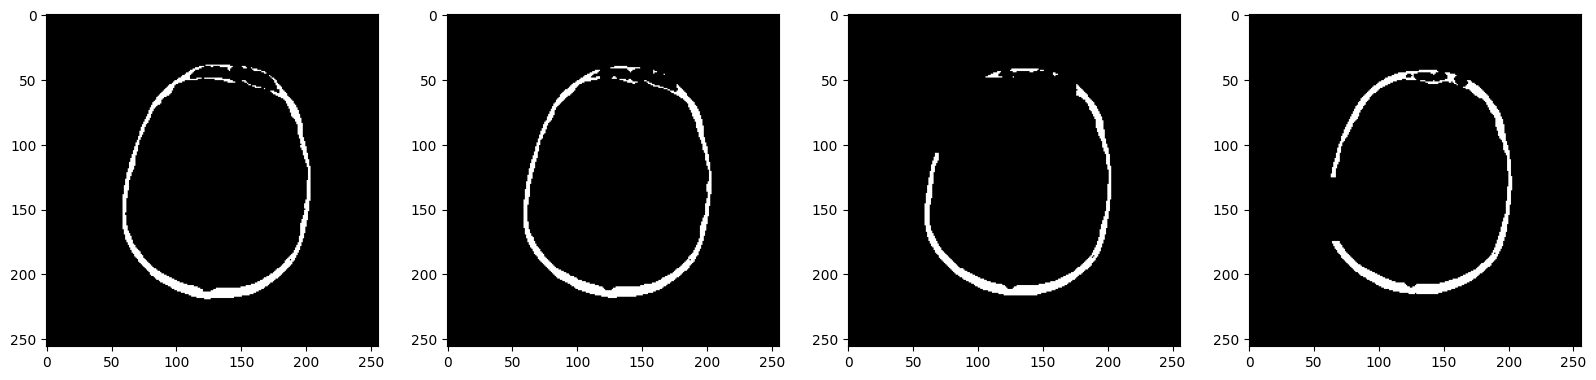

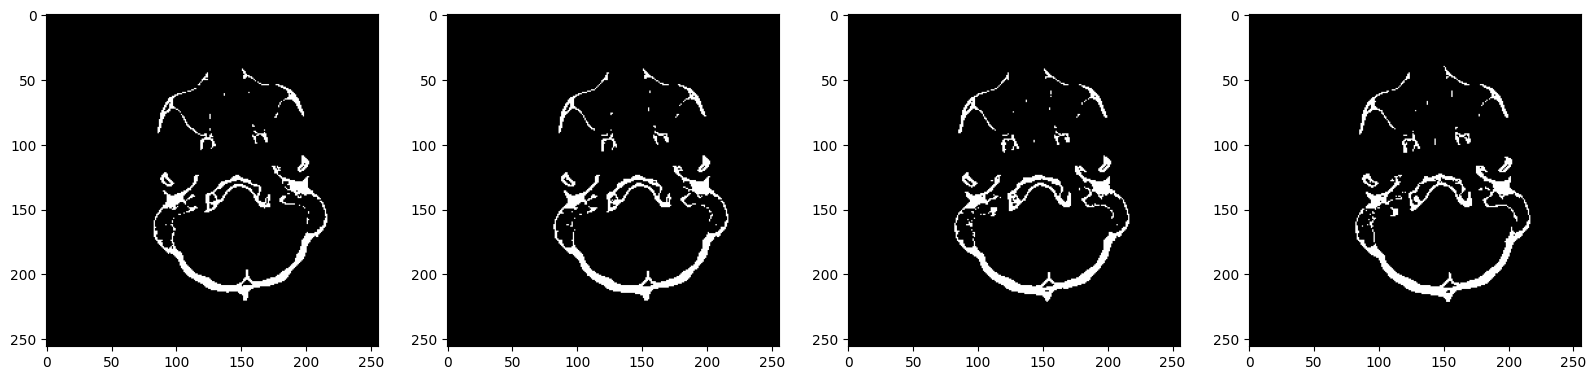

In [ ]:
plt.figure(figsize=(25,25))
DrawImages(y_trn, 4, (5,5), 40)
plt.figure(figsize=(25,25))
DrawImages(x_trn, 4, (5,5), 40)
plt.figure(figsize=(25,25))
DrawImages(x_tst, 4, (5,5), 40)

In [ ]:
pooling_size = 2
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((pooling_size, pooling_size))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p
    
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=pooling_size, stride=pooling_size, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x
    
class offset_block(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        self.max_pool = nn.MaxPool2d((pooling_size,pooling_size))
        self.dropout = nn.Dropout()
        self.flatten = nn.Flatten()
        self.fully_connected = nn.Linear(32768, input_shape)
        self.sigmoid = nn.Sigmoid()
    def forward(self, inputs):
        x = self.max_pool(inputs)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fully_connected(x)
        x = self.sigmoid(x)
        return x

In [ ]:
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        start_layer = 32
        """ Encoder """
        self.e1 = encoder_block(1, start_layer)
        self.e2 = encoder_block(start_layer, start_layer * 2**1)
        self.e3 = encoder_block(start_layer * 2**1, start_layer * 2**2)
        self.e4 = encoder_block(start_layer * 2**2, start_layer * 2**3)
        """ Bottleneck """
        self.b2 = conv_block(start_layer * 2**3, start_layer * 2**4)
        """ Decoder """
        self.d1 = decoder_block(start_layer * 2**4, start_layer * 2**3)
        self.d2 = decoder_block(start_layer * 2**3, start_layer * 2**2)
        self.d3 = decoder_block(start_layer * 2**2, start_layer * 2**1)
        self.d4 = decoder_block(start_layer * 2**1, start_layer)
        """ Classifier """
        self.outputs1 = nn.Conv2d(start_layer, start_layer, kernel_size=1, padding=0)
        self.outputs2 = nn.Conv2d(start_layer, 1, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()
    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b2 = self.b2(p4)
        """ Decoder """
        d1 = self.d1(b2, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2,s2)
        d4 = self.d4(d3,s1)
        """ Classifier """
        outputs = self.outputs1(d4)
        outputs = self.outputs2(outputs)
        outputs = self.sigmoid(outputs)
        return outputs

In [ ]:
#use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = build_unet().to(device)

In [ ]:
def train(epochs, model, criterion, optimizer, train_loader, eps):
    for epoch in range(epochs):
        loss = 0
        for batch_features, targets in train_loader:

            batch_features = batch_features.view(-1, 1, i_height, i_width).to(device) #.view(-1, 1, i_height, i_width)
            targets = targets.view(-1, 1, i_height, i_width).to(device)
            optimizer.zero_grad()
            
            # compute reconstructions
            outputs = model(batch_features)
            if(epoch%50==0):
                n_exmpl = 0
                dr_out = outputs.detach().numpy().reshape(-1, i_height, i_width)[n_exmpl]
                dr_or = batch_features.detach().numpy().reshape(-1, i_height, i_width)[n_exmpl]
                dr_tar = targets.detach().numpy().reshape(-1, i_height, i_width)[n_exmpl]

                plt.subplot(2,2,1)
                plt.title('CNN layer')
                plt.imshow(dr_out, cmap='gray')

                plt.subplot(2,2,2)
                plt.title('Original + CNN')
                plt.imshow(dr_or+dr_out, cmap='gray')
                
                plt.subplot(2,2,3)
                plt.title('Original')
                plt.imshow(dr_or, cmap='gray')

                plt.subplot(2,2,4)
                plt.title('Target')
                plt.imshow(dr_tar, cmap='gray')
                plt.show()
            # compute training reconstruction loss
            train_loss = criterion(outputs+batch_features, targets)
            
            # compute accumulated gradients
            train_loss.backward()
            
            # perform parameter update based on current gradients
            optimizer.step()
            
            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()
        
        # compute the epoch training loss
        loss = loss / len(train_loader)
        
        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
        if loss < eps:
            break
    
    return model

In [ ]:
# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

tensor_x = torch.Tensor(x_trn) # transform to torch tensor
tensor_y = torch.Tensor(y_trn)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset) # create your dataloader

train_loader = DataLoader(
    my_dataset, batch_size=64, shuffle=True
)

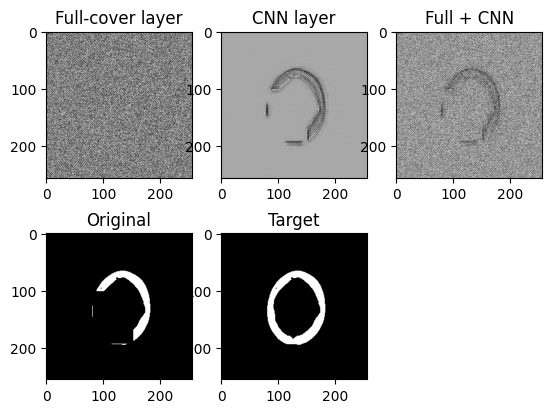

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64, 1, 256, 256])) that is different to the input size (torch.Size([64, 64, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


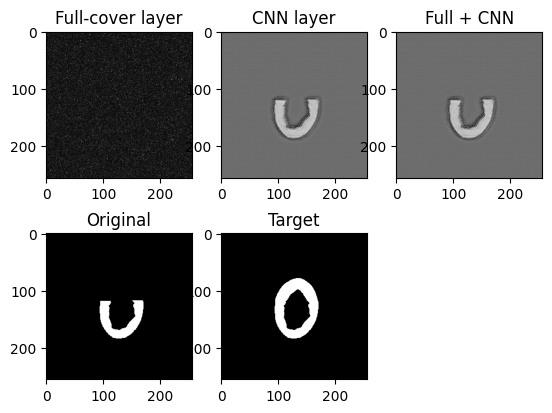

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4, 1, 256, 256])) that is different to the input size (torch.Size([4, 4, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch : 1/1000, loss = 0.639876
epoch : 2/1000, loss = 0.218011
epoch : 3/1000, loss = 0.197149
epoch : 4/1000, loss = 0.179559
epoch : 5/1000, loss = 0.166320
epoch : 6/1000, loss = 0.153435
epoch : 7/1000, loss = 0.144474
epoch : 8/1000, loss = 0.142048
epoch : 9/1000, loss = 0.133999
epoch : 10/1000, loss = 0.131061
epoch : 11/1000, loss = 0.125396
epoch : 12/1000, loss = 0.123481
epoch : 13/1000, loss = 0.119225
epoch : 14/1000, loss = 0.115729
epoch : 15/1000, loss = 0.112355
epoch : 16/1000, loss = 0.114435
epoch : 17/1000, loss = 0.110205
epoch : 18/1000, loss = 0.106286
epoch : 19/1000, loss = 0.104136
epoch : 20/1000, loss = 0.100455
epoch : 21/1000, loss = 0.100384
epoch : 22/1000, loss = 0.097834


KeyboardInterrupt: 

In [ ]:
model = train(1000, model, criterion, optimizer, train_loader, 0.003)

In [ ]:
#torch.save(model.state_dict(), '256_256_weigths')

In [ ]:
x_tst = np.array(x_tst,np.float32)
test_examples = [[]]
reconstruction = []
with torch.no_grad():
    batch_features = torch.asarray(x_tst)
    test_examples = np.array(x_tst)
    batch_features = batch_features.view(-1, 1, i_height, i_width).to(device)
    off, outputs = model(batch_features)
    off = np.array(off).reshape(-1, i_height, i_width)
    outputs = np.array(outputs).reshape(-1, i_height, i_width)
    print(off.shape, outputs.shape)
    reconstruction = np.array(off+outputs)

print(test_examples.shape)
print(reconstruction.shape)

(261, 128, 128) (261, 128, 128)
(261, 128, 128)
(261, 128, 128)


1.0002495


<Figure size 2500x2500 with 0 Axes>

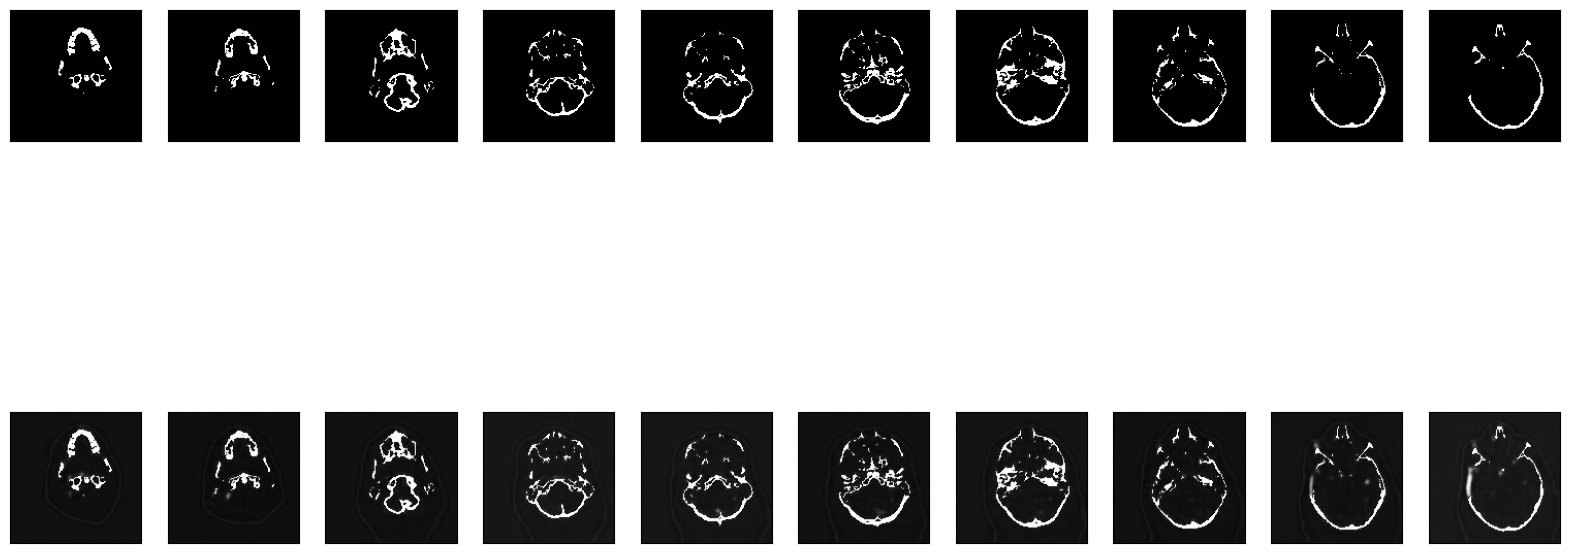

In [ ]:
plt.figure(figsize=(25,25))
print(np.max(np.array(reconstruction)))
with torch.no_grad():
    number = 100
    step = 10
    plt.figure(figsize=(20, 20))
    for index in range(0,number,step):
        # display original
        ax = plt.subplot(4, int(number/step), int(index/step)+ 1)
        plt.imshow(test_examples[index])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, int(number/step), int(index/step) + 1 + int(number/step))
        plt.imshow(reconstruction[index])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
test_examples = test_examples * max_value
reconstruction = reconstruction * max_value

In [ ]:
show_ratio = 100
v, f = make_mesh(test_examples, show_ratio,1)
plt_3d(v, f, 'test_examples.stl')

In [ ]:
print(reconstruction.min(),reconstruction.max())
v, f = make_mesh(reconstruction, 100)
plt_3d(v, f, 'reconstraction.stl')

8.627455 2065.308
